In [1]:
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
from pathlib import Path

import numpy as np
from numpy.linalg import inv
from numpy.random import dirichlet
import pandas as pd

# diff - differential functions
from sympy import symbols, solve, log, diff
from scipy.optimize import minimize_scalar, newton, minimize
# quad : to solve integral functions
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
np.random.seed(42)

DATA_STORE = Path('data/assets.h5')

In [50]:
share, odds, probability = symbols('share odds probability')
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share)
# Kelly Criertian: Optimal share of capital
solve(diff(Value, share), share)

[(odds*probability + probability - 1)/odds]

In [3]:
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f)
solve(diff(y, f), f)

[2*p - 1]

In [51]:
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/stooq'].close

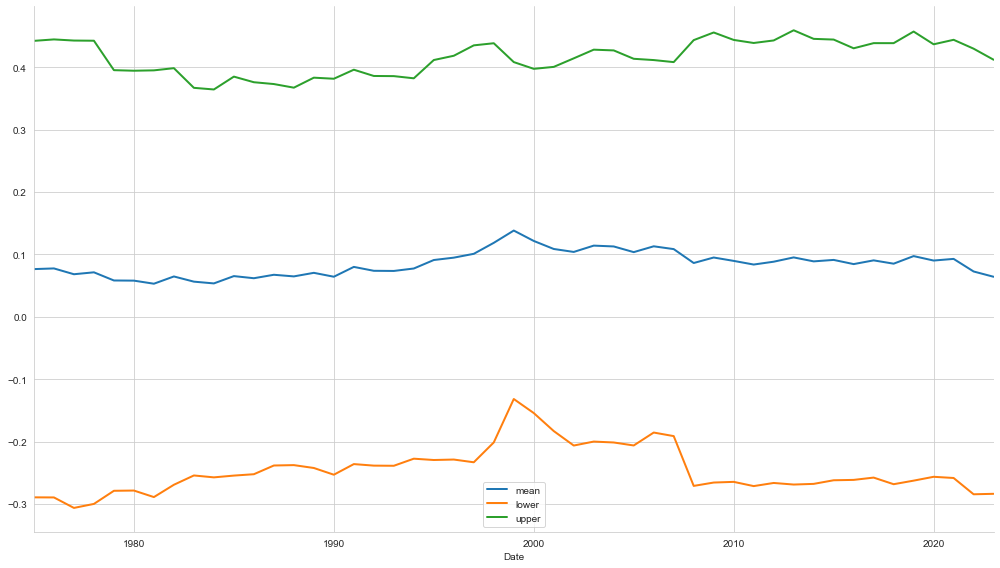

In [155]:
annual_returns = sp500.resample('A').last().pct_change().dropna().to_frame('sp500')

# .sp500 : to remove dual columns
return_params = annual_returns.sp500.rolling(25).agg(['mean', 'std']).dropna()

return_ci = (return_params[['mean']]
                .assign(lower=return_params['mean'].sub(return_params['std'].mul(2)))
                .assign(upper=return_params['mean'].add(return_params['std'].mul(2))))

return_ci.plot(lw=2, figsize=(14, 8))
plt.tight_layout()
sns.despine();

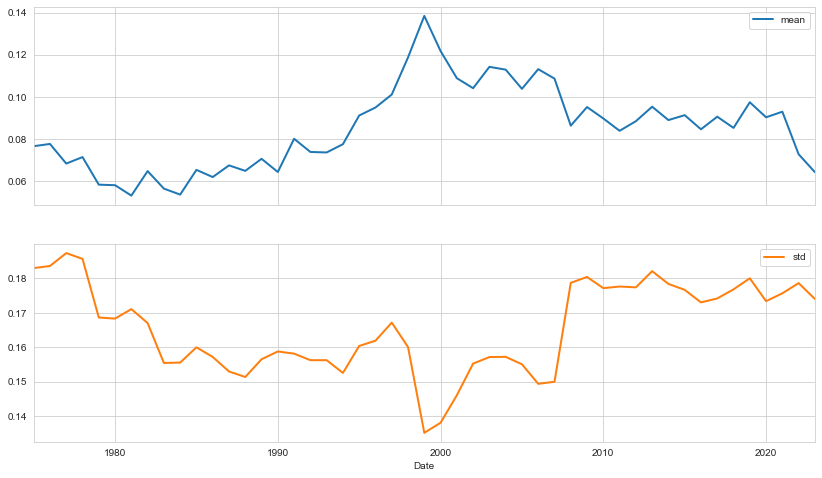

In [156]:
def norm_integral(f, mean, std):
    val, er = quad(lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std),
                   mean - 3 * std, mean + 3 * std)
    return -val

def norm_dev_integral(f, mean, std):
    val, er = quad(lambda s: (s / (1 + f * s)) * norm.pdf(s, mean, std),
                   m-3*std, mean+3*std)
    return val

def get_kelly_share(data):
    solution = minimize_scalar(norm_integral,
                        args=(data['mean'], data['std']),
                        bounds=[0, 2],
                        method='bounded')
    return solution.x

annual_returns['f'] = return_params.apply(get_kelly_share, axis=1)
return_params.plot(subplots=True, lw=2, figsize=(14, 8));

In [157]:
annual_returns.shape
annual_returns.tail()

,sp500,f
Date,,
2019-12-31,0.288781,1.999996
2020-12-31,0.162589,1.999996
2021-12-31,0.268927,1.999996
2022-12-31,-0.194428,1.994368
2023-12-31,0.054424,1.917054


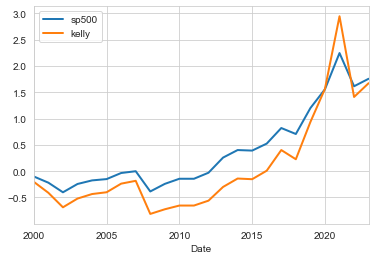

In [175]:
(annual_returns[['sp500']].assign(kelly=annual_returns.sp500.mul(annual_returns.f.shift()))
 .dropna().loc['2000':].add(1).cumprod().sub(1).plot(lw=2));

In [176]:
# Compute Kelly Fraction
m = .058
s = .216

# Option 1: minimize the expectation integral
sol = minimize_scalar(norm_integral, args=(m, s), bounds=[0., 2.], method='bounded')
print('Optimal Kelly fraction: {:.4f}'.format(sol.x))

Optimal Kelly fraction: 1.1974


In [177]:
# Option 2: take the derivative of the expectation and make it null
# scipy.optimize.newton: using when the boundary of the solution
x0 = newton(norm_dev_integral, .1, args=(m, s))
print('Optimal Kelly fraction: {:.4f}'.format(x0))

Optimal Kelly fraction: 1.1974


In [179]:
# For Multiple assets by Kelly Rule
with pd.HDFStore(DATA_STORE) as store:
    sp500_stocks = store['sp500/stocks'].index
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14277 entries, 1962-01-02 to 2018-03-27
Columns: 458 entries, MMM to ZTS
dtypes: float64(458)
memory usage: 50.0 MB


In [180]:
monthly_returns = prices.loc['1988':'2017'].resample('M').last().pct_change().dropna(how='all').dropna(axis=1)
stocks = monthly_returns.columns
monthly_returns.head()

ticker,MMM,AOS,ABT,ADM,ADBE,ADP,AFL,APD,ALK,LNT,...,WMT,WEC,WFC,WST,WDC,WY,WHR,WMB,GWW,XEL
date,,,,,,,,,,,,,,,,,,,,,
1988-02-29,-0.016015,0.107451,0.066667,0.051373,0.094340,0.084912,-0.025965,0.163636,0.147541,0.038251,...,0.073046,-0.014866,0.077426,-0.137391,0.234043,0.134737,0.072335,0.142330,0.055649,-0.023039
1988-03-31,-0.025424,0.080028,-0.098462,-0.036145,0.068966,-0.081417,0.170749,-0.059891,-0.035429,-0.047368,...,-0.041615,-0.024438,-0.050562,-0.084677,0.026207,-0.101345,-0.053571,0.000000,0.014936,-0.024129
1988-04-30,0.028174,-0.057049,-0.020838,0.125000,0.129032,-0.058824,-0.068923,0.077986,0.121154,0.001899,...,-0.013158,0.020202,-0.014675,0.005232,0.024866,-0.025207,0.028302,0.159273,0.135318,-0.003984
1988-05-31,0.053712,0.000000,0.016217,-0.038069,0.007143,-0.031250,-0.074686,-0.059529,-0.086335,-0.002697,...,0.018018,0.050463,0.027195,0.082966,0.000000,-0.020000,-0.026255,-0.036158,-0.041457,0.041667
1988-06-30,0.068826,0.105263,-0.029545,-0.063800,0.141844,0.048455,-0.045000,0.119104,0.108406,0.047769,...,0.085369,0.014548,0.124260,-0.025085,0.008525,0.117551,0.095238,0.028976,-0.050530,0.012866


In [181]:
cov = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov), index=stocks, columns=stocks)
kelly_allocation = monthly_returns.mean().dot(precision_matrix)
precision_matrix.head()

ticker,MMM,AOS,ABT,ADM,ADBE,ADP,AFL,APD,ALK,LNT,...,WMT,WEC,WFC,WST,WDC,WY,WHR,WMB,GWW,XEL
ticker,,,,,,,,,,,,,,,,,,,,,
MMM,1775.048648,-23.713293,169.892557,-97.714490,44.048342,32.318590,-16.694364,-134.848655,40.003974,-112.722344,...,27.839474,-223.130331,-37.050707,20.926922,-35.454514,-244.172086,-54.750782,3.014826,60.691390,-82.663367
AOS,-23.713293,356.122856,-104.943322,18.239236,34.413369,-50.312333,13.948220,20.034121,58.721774,-77.203205,...,-32.425296,17.731191,15.584972,-55.155017,10.332825,15.693755,-32.779035,-17.401857,44.391949,52.276745
ABT,169.892557,-104.943322,1233.287788,-90.331475,-98.607455,113.402323,-7.886019,43.622837,8.914850,-92.192759,...,14.487045,70.892478,-69.945690,119.490594,-67.464647,-112.118648,46.723843,-33.805096,-2.063612,111.016716
ADM,-97.714490,18.239236,-90.331475,511.365340,38.617954,-56.027108,0.560849,16.667225,1.300703,-101.888328,...,-91.355659,-2.619628,1.849365,-43.357940,35.469457,36.798657,-72.946455,-18.939336,-53.544392,-44.267017
ADBE,44.048342,34.413369,-98.607455,38.617954,237.633949,-53.664134,-52.431011,0.958198,12.646740,61.420428,...,16.134353,68.125962,24.334909,-13.755315,28.998402,-34.994819,-59.897578,5.183300,-19.174623,-145.057163


In [184]:
kelly_allocation.describe()

count    193.000000
mean       0.252466
std        3.376205
min       -9.583007
25%       -1.712525
50%        0.216006
75%        2.136321
max        9.562480
dtype: float64

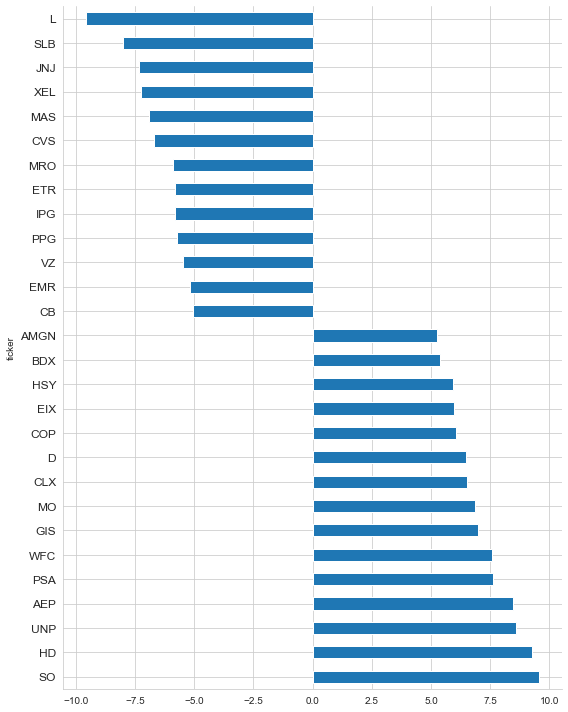

In [185]:
kelly_allocation[kelly_allocation.abs()>5].sort_values(ascending=False).plot.barh(figsize=(8, 10))
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout();

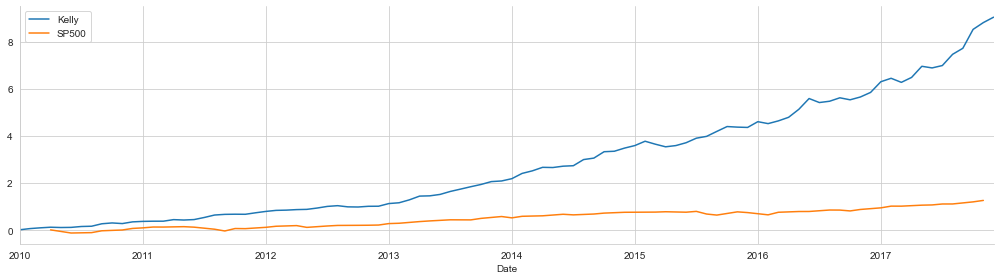

In [186]:
ax = monthly_returns.loc['2010':].mul(kelly_allocation.div(kelly_allocation.sum())).sum(1).to_frame('Kelly').add(1).cumprod().sub(1).plot(figsize=(14,4));
sp500.filter(monthly_returns.loc['2010':].index).pct_change().add(1).cumprod().sub(1).to_frame('SP500').plot(ax=ax, legend=True)
plt.tight_layout()
sns.despine();